# Digging into Semantic Segmentation

Segmentaion is a type of computer vision problem, in which the goal is to identify each pixel of the image with respect to its class. There are three main types of segmentaion such as Panoptic segmentation, Instance segmentation and Semanti Segmenation.

# Our Goal

In this competion, the goal is to segment over 23 classes, The dataset is generated using Carla simulator.

In this notebook, I will explain on how to tackle this problem with Pytorch and Unets and share some common jargons in semantic segmenation task 

Let's dive in.

#### Download the Dataset

Let's download the dataset using aicrowd cli

In [1]:
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [2]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/aO-Aoy1oKjPFh7eSNNgZs28veDOPcPrRJ0Y5myfb34E
API Key valid
Saved API Key successfully!


In [3]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c scene-segmentation -o data

test.zip:   0%|          | 0.00/33.7M [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/166M [00:00<?, ?B/s]

In [4]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/test.zip -d data/test > /dev/null

In [5]:
! pip install albumentations==0.4.6
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

     |████████████████████████████████| 117 kB 12.8 MB/s 
     |████████████████████████████████| 948 kB 22.8 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=7bd1df8fb935b6c9209d9bd3db3b5fb53d49163662068f0b64fd488fdd8ffd30
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-pla1wl27
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-pla1wl27
     |████████████████████████

## Imports

In [21]:
import torch
import torch.nn as nn  
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader

import albumentations as albu
import segmentation_models_pytorch as smp
from natsort import natsorted
import os
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm


## Load the Dataset

The dataset directory structure is this



```
data
--test
---image         #directory containing test images
--train
---image         #directory containing train images
---segmentation  #direcory containing train segmentation(masks)
```

Now, we'll load the dataset using Pytorch dataset class and create dataloaders for predicting the pixels


In [7]:
class SemanticSegmentationDataset(Dataset):

  """
  Creates a segmentation dataset with options to maugmentations
  """

  def __init__(self,  
               img_directory = None, 
               label_directory = None,
               mode = 'train',
               augmentation=None,
               preprocessing = None

               ):
    self.img_directory = img_directory
    self.label_directory = label_directory

    if img_directory is not None:
      self.img_list = natsorted(os.listdir(img_directory))
      self.label_list = natsorted(os.listdir(label_directory))
    
    self.mode = mode
    self.labels = list(range(0, 25)) #we have over 23 classes
    self.augmentation = augmentation
    self.preprocessing = preprocessing
  
  def __len__(self):
    return len(self.img_list)
  
  def __getitem__(self, idx):
    image = Image.open(os.path.join(self.img_directory, self.img_list[idx]))
    image = image.convert('L') #converts to grayscale


    if self.mode == 'train' or self.mode == 'val':
          mask = Image.open(os.path.join(self.label_directory, self.label_list[idx]))

          image = np.array(image, dtype=np.float32)
          mask = np.array(mask, dtype=np.float32)

          image = image[np.newaxis, :, :]
          image = torch.from_numpy(image)
          image = image.float()/255

          binary_mask = np.array([(mask == v) for v in list(self.labels)])
          binary_mask = np.stack(binary_mask, axis=-1).astype('float')

          mask_preprocessed = binary_mask.transpose(2, 0, 1)
          mask_preprocessed = torch.from_numpy(mask_preprocessed)

          #apply augmentation
          if self.augmentation:
            sample = self.augmentation(image=image, mask=mask_preprocessed)
            image, mask_preprocessed = sample['image'], sample['mask']

          #apply preprocessing
          if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask_preprocessed)
            image, mask_preprocessed = sample['image'], sample['mask']
            

          return image, mask_preprocessed

    else:
          image = np.array(image, dtype=np.float32)
          image = image[np.newaxis, :, :]
          image = torch.from_numpy(image)
          image = image.float()/255
          return image

## Model Architecture

There are many different types of architectures, that can be used for training segmentation models.

The main popular architectures are,


*   Unet
*   Unet++
*   FPN
*   MAnet
*  Linknet
*  PSPNet
* PAN
* DeepLabV3
* DeepLabV3+


These architectures are also available in segmentation models pytorch toolkit. For this tutorial, we will focus only on UNET.


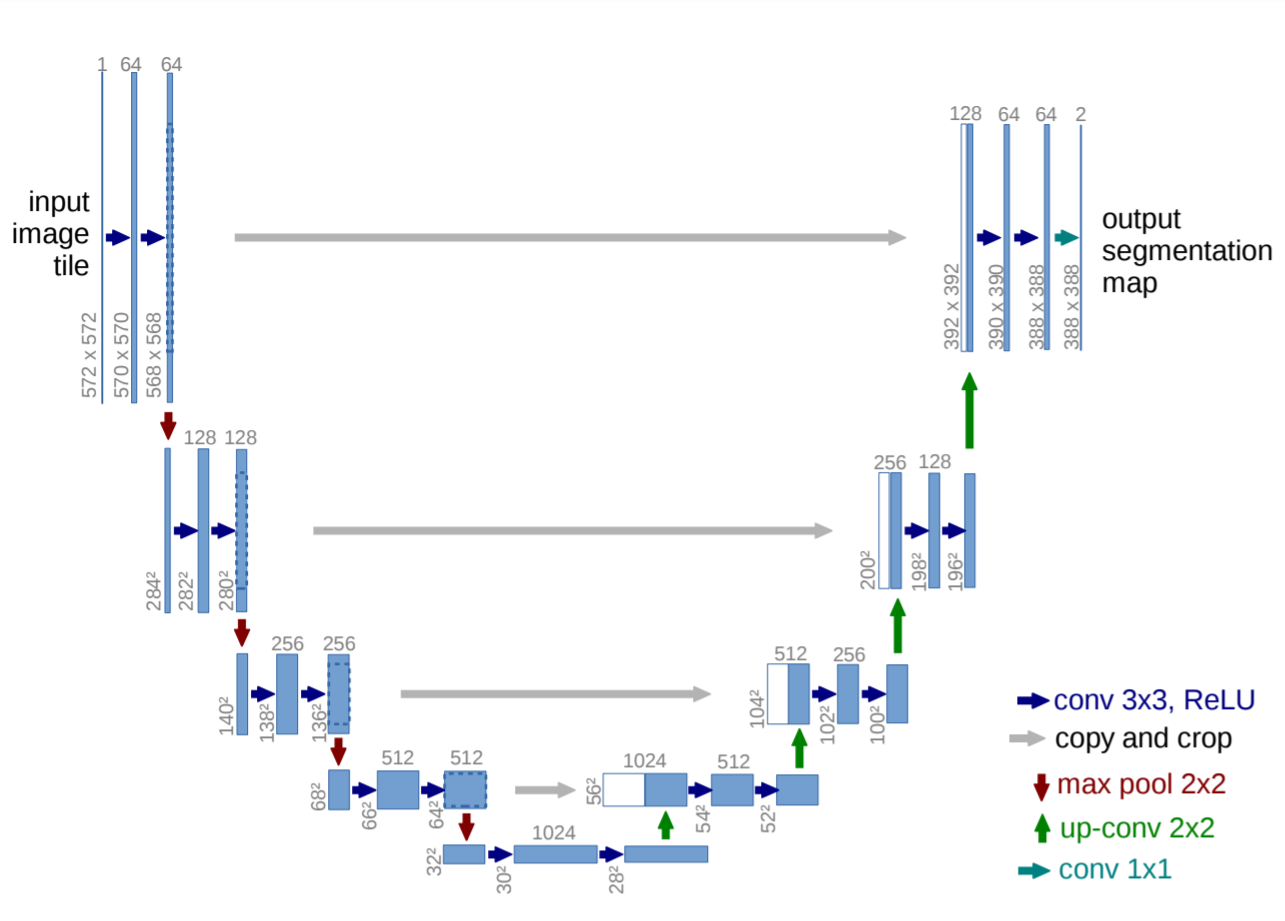

As you can notice from the above figure, the architecture is in the U shape. The left block is called as an Encoder block and the right block is considered as decoder block.


The encoder is mostly a CNN, which extracts meaningful feature map from an input image, also it doubles the number of channels in each step and downsample the image, i.e reduce the height and width.

The decoder upsamples the feature maps and halves the number of channels and outputs a segmentation map, which is the region of pixels


For this competition, we will use Segmentation models pytorch library which consists of handful of utility functions to create architecture and load the pretrained encoders

In [8]:
train_dataset = SemanticSegmentationDataset(img_directory = "data/train/image", 
                                        label_directory = "data/train/segmentation",
                                        mode='train',  
                                        augmentation=None,
                                        preprocessing=None
                                        )
train_loader = DataLoader(train_dataset,
                          batch_size=8, 
                          shuffle=True, 
                          drop_last=True,
                          )

In [9]:
ENCODER = 'resnet18' 
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = "softmax2d" 
DEVICE = 'cuda'

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(train_dataset.labels),
    in_channels=1,
    activation=ACTIVATION,
)


preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
#create dataset  and dataloaders
train_dataset = SemanticSegmentationDataset(img_directory = "data/train/image", 
                                        label_directory = "data/train/segmentation",
                                        mode='train',  
                                        augmentation=None,
                                        preprocessing=None
                                        )
train_loader = DataLoader(train_dataset,
                          batch_size=8, 
                          shuffle=True, 

                          drop_last=True,
                          )

### Loss Functions

Several loss functions could be used for semantic segmentation task, the ones that you see often are



*  Dice Loss

Dice Loss is derived from Sørensen–Dice coefficient, which is a statistical term, that used to measure similarity between two samples.

*   Focal Loss

Focal loss is also used for image classification, it is mainly used when we have a highly imbalanced dataset and when we need a model to take risk and predict as a false positive, instead of negative result, which is important in medical diagnostic problems. 

*  Jaccard Loss

Jaccard Loss is similar to dice loss, it is commonly used to train segmentation mdodels, it is also called as an IoU metric.It is calculated as the ratio between the overlap of the positive instances between two sets, and their mutual combined values.


We will use standard Dice Loss for this tutorial



In [12]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
]

optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.006)

In [13]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss = loss, 
    metrics = metrics, 
    optimizer = optimizer,
    device = DEVICE,
    verbose = True,
)


For the sake of this tutorial, I will train only for 5 epochs

In [14]:
max_score = 0

for i in range(0, 5): 
  print('\nEpoch: {}'.format(i + 1))
  train_logs = train_epoch.run(train_loader)
  #valid_logs = valid_epoch.run(val_loader)
  curr_score = train_logs['fscore']
  #save the best model based on f1-score

  if max_score < curr_score:
    max_score = curr_score
    torch.save(model, 'result.pth')
    print('Model saved!')

  torch.save(model, 'last.pth')


Epoch: 1
train:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train: 100%|██████████| 500/500 [19:38<00:00,  2.36s/it, dice_loss - 0.2108, iou_score - 0.6586, fscore - 0.7903, accuracy - 0.9836, recall - 0.7888, precision - 0.7948]
Model saved!

Epoch: 2
train: 100%|██████████| 500/500 [19:29<00:00,  2.34s/it, dice_loss - 0.1911, iou_score - 0.6806, fscore - 0.8089, accuracy - 0.9847, recall - 0.8089, precision - 0.8089]
Model saved!

Epoch: 3
train: 100%|██████████| 500/500 [19:32<00:00,  2.34s/it, dice_loss - 0.1911, iou_score - 0.6805, fscore - 0.8089, accuracy - 0.9847, recall - 0.8089, precision - 0.8089]

Epoch: 4
train: 100%|██████████| 500/500 [19:28<00:00,  2.34s/it, dice_loss - 0.1887, iou_score - 0.6837, fscore - 0.8113, accuracy - 0.9849, recall - 0.8113, precision - 0.8113]
Model saved!

Epoch: 5
train: 100%|██████████| 500/500 [19:29<00:00,  2.34s/it, dice_loss - 0.1877, iou_score - 0.6852, fscore - 0.8123, accuracy - 0.985, recall - 0.8123, precision - 0.8123]
Model saved!


### Submitting predictions with the test dataset

In [18]:
# Creating the testing dataset

test_dataset = SemanticSegmentationDataset(img_directory="data/test/image", mode="test")
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=2, shuffle=False, drop_last=False)

In [23]:
# Generating Model Predictions
!rm -rf segmentation
!mkdir segmentation

for n, batch in enumerate(tqdm(test_loader)):

  # Getting the predictions
  predictions = model.predict(batch.to(DEVICE)).cpu() 
  
  # Converting the predictions to right format
  prediction_mask = (predictions.squeeze().cpu().numpy())   
  prediction_mask = np.transpose(prediction_mask, (1, 2, 0))

  # Getting individual channel and combining them into single image
  prediction_mask_gray = np.zeros((prediction_mask.shape[0],prediction_mask.shape[1]))
  for i in range(prediction_mask.shape[2]):
    prediction_mask_gray = prediction_mask_gray + i*prediction_mask[:,:,i].round()


  # Saving the image
  prediction_mask_gray = Image.fromarray(prediction_mask_gray.astype(np.uint8))
  prediction_mask_gray.save(os.path.join("segmentation", f"{n}.png"))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
!aicrowd notebook submit -c scene-segmentation -a segmentation --no-verify

/usr/local/lib/python3.7/dist-packages/aicrowd/notebook/helpers.py:361: UserWarning: `%aicrowd` magic command can be used to save the notebook inside jupyter notebook/jupyterLab environment and also to get the notebook directly from the frontend without mounting the drive in colab environment. You can use magic command to skip mounting the drive and submit using the code below:
 %load_ext aicrowd.magic
%aicrowd notebook submit -c scene-segmentation -a segmentation --no-verify
  warnings.warn(description + code)
Mounting Google Drive 💾
Your Google Drive will be mounted to access the colab notebook
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%

## Extra Resources to learn segmentation:

[1] Jeremy jordan's blogpost: jeremyjordan.me/semantic-segmentation/


[2] Unet from scratch by Aladdin Person: https://www.youtube.com/watch?v=IHq1t7NxS8k

[3] Unet from scratch by Aman Arora: https://amaarora.github.io/2020/09/13/unet.html
